## Ablation Study: DnD with BLIP2

In [1]:
# Import libraries

import os
import sys
sys.path.append("..")

import torch
import utils
import data_utils
import DnD_models
import scoring_function

import pandas as pd
import random

from diffusers import StableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler

from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import Blip2Processor, Blip2ForConditionalGeneration

### Experiment Settings

In [2]:
# Define variables for dissection

figure = 'fig22b'

settings = {'fig22a': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer2', "ids_to_check": [25], "blip": 'blip'},
            'fig22b': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer2', "ids_to_check": [25], "blip": 'blip2'},
            'fig22c': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer4', "ids_to_check": [600], "blip": 'blip'},
            'fig22d': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer4', "ids_to_check": [600], "blip": 'blip2'},
            'fig23a': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer1', "ids_to_check": [92, 202], "blip": 'blip'},
            'fig23b': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer1', "ids_to_check": [92, 202], "blip": 'blip2'},
           }

clip_name = 'ViT-B/16'
target_name = settings[figure]["target_name"]
target_layer = settings[figure]["target_layer"]
d_probe = settings[figure]["d_probe"]

batch_size = 200
device = 'cuda'
pool_mode = 'avg'

results_dir = 'exp_results'
saved_acts_dir = 'saved_activations'
num_images_to_check = 10
blip_batch_size = 10
tag = "_"

blip = settings[figure]["blip"]
ids_to_check = settings[figure]["ids_to_check"]

### Load Models

In [3]:
# Load BLIP or BLIP2 model

BLIP_OR_BLIP2_PATH = ""

if blip == 'blip':
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device) 
if blip == 'blip2':
    processor = Blip2Processor.from_pretrained('Salesforce/blip2-opt-2.7b')
    model = Blip2ForConditionalGeneration.from_pretrained('Salesforce/blip2-opt-2.7b').to(device) 
pretrained_dict = torch.load(BLIP_OR_BLIP2_PATH)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [4]:
# Initialize Stable Diffusion

model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))
generator = torch.Generator(device=device).manual_seed(0)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### Set Up Results File

In [5]:
# Setting up file/directory paths for saving results
pot_column_names = ['Neuron ID'] + ['Concept {}'.format(i) for i in range(5)]
all_concepts = pd.DataFrame(columns=pot_column_names)
result_column_names = ['Neuron ID', 'Label 1', 'Label 2', 'Label 3']
final_concepts = pd.DataFrame(columns=result_column_names)

In [6]:
# Create results folder
results_path = utils.create_layer_folder(results_dir = results_dir, base_dir = ".", target_name = target_name, 
                          d_probe = d_probe, layer = target_layer, tag = tag)

### Construct Augmented Probing Data (DnD Step 1)

In [7]:
# Get activations
target_save_name = utils.get_save_names(target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  pool_mode=pool_mode, base_dir = '.', saved_acts_dir = saved_acts_dir)

utils.save_activations(target_name = target_name, target_layers = [target_layer],
                       d_probe = d_probe, batch_size = batch_size, device = device,
                       pool_mode=pool_mode, base_dir = '.', saved_acts_dir = saved_acts_dir)

target_feats = torch.load(target_save_name, map_location='cpu')

pil_data = data_utils.get_data(d_probe)

In [8]:
# Find top activating images
top_vals, top_ids = torch.topk(target_feats, k=num_images_to_check, dim=0)

all_imgs = []
all_img_ids = {neuron_id:[] for neuron_id in ids_to_check}

# Find top activating image crops
for t, orig_id in enumerate(ids_to_check):
    print("Cropping for Neuron {}/{}".format(t+1,len(ids_to_check)))
    
    activating_images = []
    for i, top_id in enumerate(top_ids[:, orig_id]):
        
        # Reshape activating images
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        
        # Add image to d_probe with image ID
        all_img_ids[orig_id].append(len(all_imgs))
        all_imgs.append(im)
        activating_images.append(im)
        
    cropped_images = []
    
    # Get crops - FC layers do not have feature maps
    if(target_layer != 'fc'):
        cropped_images = DnD_models.get_attention_crops(target_name, activating_images, orig_id, num_crops_per_image = 4, target_layers = [target_layer], device = device)

    # Add crops into d_probe with image ID
    for img in cropped_images:
        all_img_ids[orig_id].append(len(all_imgs))
        all_imgs.append(img)

Cropping for Neuron 1/1


### Generative Captioning with BLIP 2 (DnD Step 2)

Neuron: 25 (1/1)


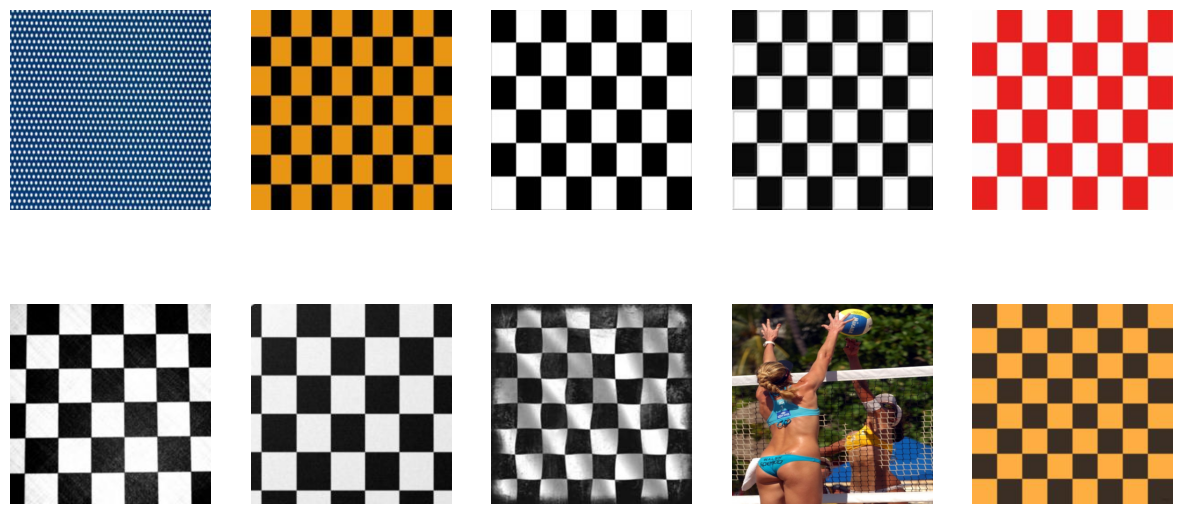

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Candidate Concept 1: Checkered patterns and activities
Candidate Concept 2: Patterned Textures
Candidate Concept 3: Checkered and patterned designs
Candidate Concept 4: Patterned textures
Candidate Concept 5: Checkered motifs


In [9]:
# Get target activations with D_probe + D_cropped
target_feats = utils.get_target_activations(target_name, all_imgs, [target_layer])

# Find top activating images
top_vals, top_ids = torch.sort(target_feats, dim=0, descending = True)
comp_words = {orig_id : [] for orig_id in ids_to_check}
top_images = {orig_id:[] for orig_id in ids_to_check}

# Step 2 - Generate Candidate Concepts
for neuron_num, orig_id in enumerate(ids_to_check):
    print("Neuron: {} ({}/{})".format(orig_id, neuron_num+1, len(ids_to_check)))

    # Plot and save highest activating images
    fig, images, top_images = utils.get_top_images(orig_id, top_ids, top_images, 
                                                   all_imgs, all_img_ids, num_images_to_check, 
                                                   blip_batch_size)
    utils.save_activating_fig(fig, results_path, orig_id)
    
    # Generate and simplify BLIP or BLIP2 Captions
    descriptions = DnD_models.blip_caption(model, processor, images, blip_batch_size, device)
    for i, description in enumerate(descriptions):
        descriptions[i] = DnD_models.GPT_simplify(description)

    # Summarize BLIP descriptions
    for i in range(5):
        cand_concept = DnD_models.GPT_model_single(descriptions)
        comp_words[orig_id].append(cand_concept)
        random.shuffle(descriptions)
        print("Candidate Concept {}: {}".format(i+1, cand_concept))
    all_concepts.loc[len(all_concepts)] = [orig_id] + comp_words[orig_id]

# Save candidate concepts
utils.save_potential_concepts(all_concepts, results_path)

### Best Concept Selection (DnD Step 3)

In [10]:
"""
We adjust concepts with certain vague words to help SD generation
"""

replace_set = ['design','designs','graphic','graphics']
for orig_id in ids_to_check:
    comp_words[orig_id] = [concept.lower() for concept in comp_words[orig_id]]
    for i, word in enumerate(comp_words[orig_id]):
        if word[-1] == '.':
            comp_words[orig_id][i] = word[:-1]
        if word.split()[-1] in replace_set:
            new_concept = word + ' background'
            comp_words[orig_id].append(new_concept)
    comp_words[orig_id] = list(set(comp_words[orig_id]))

In [11]:
pil_data = data_utils.get_data(d_probe)
d_probe_len = len(pil_data)
all_final_results = {neuron_id : [] for neuron_id in ids_to_check}

num_images_per_prompt = 10
top_K_param = 10
beta_images_param = 5
scoring_func = 'topk-sq-mean'

sd_prompt = 'One realistic image of {}'
num_inference_steps = 50

# Step 3 Main Code
for list_id, orig_id in enumerate(ids_to_check):

    # Initialize starting concepts
    word_list = comp_words[orig_id]
    
    print("Neuron {}".format(orig_id))

    # Account for modified candidate concept (if necessary)
    labels_to_check = len(word_list)

    print("# Labels to Check: {}".format(labels_to_check), "   # Images per Concept: {}".format(num_images_per_prompt))

    add_im = {}
    add_im_id = {}
    all_sd_imgs = []

    # Generate images for each label
    for label_id in range(labels_to_check):
        
        print("Label {}/{}: {}".format(label_id + 1, labels_to_check, word_list[label_id]))
        pred_label = sd_prompt.format(word_list[label_id])
        add_im_id[label_id] = []
        
        add_im, add_im_id, all_sd_imgs = DnD_models.generate_sd_images(add_im, add_im_id, all_sd_imgs, 
                                                                  pred_label, label_id, pipe, generator,
                                                                  num_images_per_prompt, num_inference_steps)
    
    # Concept Scoring
    target_feats = utils.get_target_activations(target_name, all_sd_imgs, [target_layer])
    
    ranks, highest_activating = utils.rank_images(target_feats, orig_id, labels_to_check,
                                                 add_im_id, add_im, top_K_param)
    
    clip_weight = scoring_function.compare_images(top_images[orig_id], highest_activating, clip_name, 
                                                  device, target_name, top_K_param)
    
    top_avg_topk = scoring_function.get_score(ranks, mode = scoring_func, hyp_param = beta_images_param)
    
    top_avg_comb = []
    for i in range(len(clip_weight)):
        concept_rank = len(top_avg_topk) - scoring_function.find_by_last(top_avg_topk, clip_weight[i][1])
        weight = clip_weight[i][0]
        concept_score = concept_rank * weight
        top_avg_comb.append((concept_score, clip_weight[i][1]))
        
    top_avg_comb.sort(reverse = True)
    
    # Save results in .csv file
    for label_num in range(3):
        if(label_num < len(top_avg_comb)):
            all_final_results[orig_id] += [word_list[top_avg_comb[label_num][1]]]
        else:
            all_final_results[orig_id] += [' ']
    final_concepts.loc[len(final_concepts)] = [orig_id] + all_final_results[orig_id]
    
    # Print results
    print('------------------------------\n')
    print('Neuron {}:'.format(orig_id))
    for k, word in enumerate(all_final_results[orig_id]):
        if(word != " "):
            print("Label {}: {}".format(k + 1, word))
        else:
            break
    print('\n------------------------------')
    
utils.save_final_results(final_concepts, results_path)

Neuron 25
# Labels to Check: 5    # Images per Concept: 10
Label 1/5: checkered patterns and activities


  0%|          | 0/50 [00:00<?, ?it/s]

Label 2/5: checkered and patterned designs


  0%|          | 0/50 [00:00<?, ?it/s]

Label 3/5: checkered and patterned designs background


  0%|          | 0/50 [00:00<?, ?it/s]

Label 4/5: patterned textures


  0%|          | 0/50 [00:00<?, ?it/s]

Label 5/5: checkered motifs


  0%|          | 0/50 [00:00<?, ?it/s]

------------------------------

Neuron 25:
Label 1: checkered patterns and activities
Label 2: checkered and patterned designs
Label 3: checkered and patterned designs background

------------------------------
